# Fitting VLE Data for Acetonitrile (1) , 2-Propanol (2)

In [3]:
import scipy
import scipy.optimize as scopt
import scipy.linalg as sclin
import scipy.integrate as scint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from NRTL import NRTL
from PureComponentData import purecomponentdata

In [5]:
df_vle = pd.read_excel('Acetonitrile_2Propanol_VLE_Data.xlsx', usecols = 'A:E')
#df_vle = df_vle[["P","x1","y1","T","Ref"]]


<ol>
<li>$T$: Temperature in K </li>
<li>$x1$: Liquid Phase Mole Fraction of Acetonitrile </li>
<li>$y1$: Vapour Phase Mole Fraction of Acetonitrile</li>
<li>$P$ : Pressure in kPa </li>
<li>Ref:  1 = Isothermal (15 points) , 2 = Isobaric (17 points)  , 3 = Isobaric (21 points) </li>
</ol>

In [6]:
df_vle.head(10)

,P,x1,y1,T,Ref
0,28.078,0.047,0.182,323.15,1
1,32.344,0.127,0.336,323.15,1
2,33.731,0.164,0.372,323.15,1
3,35.357,0.220,0.430,323.15,1
4,35.850,0.236,0.446,323.15,1
5,36.984,0.301,0.484,323.15,1
6,38.504,0.431,0.550,323.15,1
7,39.303,0.546,0.602,323.15,1
8,39.543,0.637,0.642,323.15,1
9,39.143,0.763,0.715,323.15,1


In [7]:
actl = purecomponentdata.Compound("Acetonitrile")
ipa = purecomponentdata.Compound('2-Propanol')

## Data Processing : 

### Removing the Pure component data points : 

In [8]:
df_vle = df_vle[df_vle.x1 > 0] ; df_vle = df_vle[df_vle.x1 < 1] 

In [9]:
df_1 = df_vle[df_vle.Ref == 1]
df_2 = df_vle[df_vle.Ref == 2]
df_3 = df_vle[df_vle.Ref == 3]

In [10]:
len(df_1) + len(df_2) + len(df_3)

49

## Visualising Data :

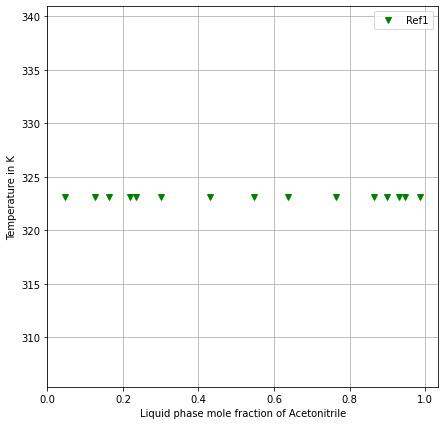

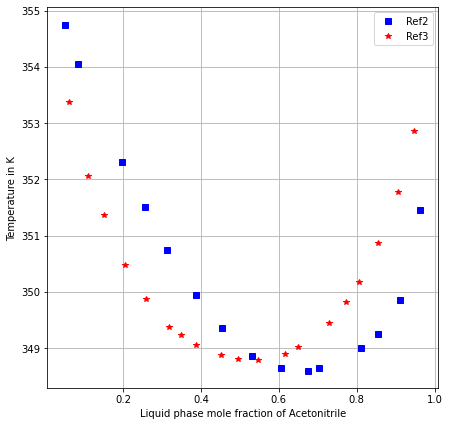

In [11]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["T"], 'gv')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Temperature in K")
plt.legend(["Ref1"])
plt.grid()

plt.figure(figsize = (7,7))
plt.plot(df_2["x1"], df_2["T"], 'bs')
plt.plot(df_3["x1"], df_3["T"], 'r*')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Temperature in K")
plt.legend(["Ref2","Ref3"])
plt.grid()


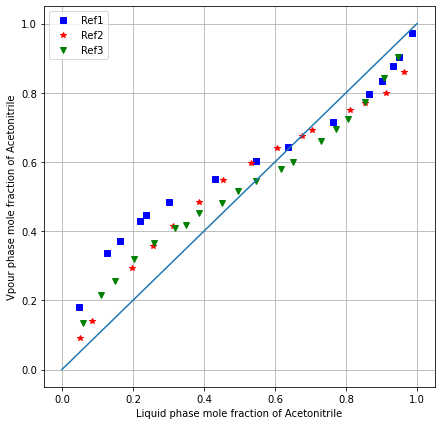

In [12]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["y1"], 'bs')
plt.plot(df_2["x1"], df_2["y1"], 'r*')
plt.plot(df_3["x1"], df_3["y1"], 'gv')
plt.plot([0,1], [0,1])
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Vpour phase mole fraction of Acetonitrile")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

## Vapour Liquid Equilibrium
$$
    P_T y_i = \gamma_i x_i P_i^{vap}(T) 
$$
i.e.
$$
    \gamma_i = \frac{P_T y_i}{x_i P_i^{vap}(T)}
$$
where, $P_T$ is the total pressure, $y_i$ the vapour phase mol fraction of component $i$, $x_i$ the corresponding liquid phase mole fraction and $P_i^{vap}$ is the saturation vapour pressure of $i$ at the temperature $T$.

In [13]:
def get_expt_gamma_1(row):
    x1 = row["x1"]
    y1 = row["y1"]
    T  = row["T"]
    Psat = actl.Pvap(T)
    P = row["P"]*1000
    gamma = P*y1/(x1*Psat)
    return gamma

def get_expt_gamma_2(row):
    x2 = 1 - row["x1"] 
    y2 = 1 - row["y1"]
    T = row["T"]
    Psat = ipa.Pvap(T)
    P = row["P"]*1000
    gamma = P*y2/(x2*Psat)
    return gamma

df_vle["gamma_1"] = df_vle.apply(get_expt_gamma_1, axis = 1)
df_vle["gamma_2"] = df_vle.apply(get_expt_gamma_2, axis = 1)


In [14]:
df_1 = df_vle[df_vle.Ref == 1]
df_2 = df_vle[df_vle.Ref == 2]
df_3 = df_vle[df_vle.Ref == 3]

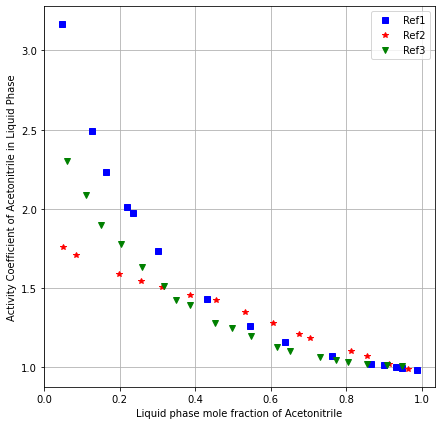

In [15]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["gamma_1"], 'bs')
plt.plot(df_2["x1"], df_2["gamma_1"], 'r*')
plt.plot(df_3["x1"], df_3["gamma_1"], 'gv')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of Acetonitrile in Liquid Phase")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

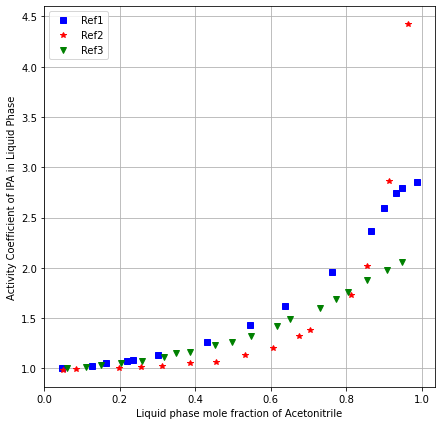

In [16]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["gamma_2"], 'bs')
plt.plot(df_2["x1"], df_2["gamma_2"], 'r*')
plt.plot(df_3["x1"], df_3["gamma_2"], 'gv')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of IPA in Liquid Phase")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

## Parameters to Fit
We will try to model the VLE data with NRTL by fitting the following adjustable parameters (1 = ipa, 2 = water).
<ol>
<li> $a_{12}$ and $a_{21}$</li>
<li> $\alpha_{12} = \alpha_{21} \; \; $ (This is fixed ) </li>
</ol>

In [17]:
nrtl = NRTL.NRTL(["actl", "ipa"])

In [18]:
def get_nrtl_gammas(row, nrtl):
    x1 = row["x1"]
    x2 = 1 - x1
    T = row["T"]
    dict_gammas = nrtl.get_gammas(T, {"ipa":x2, "actl":x1})
    return pd.Series({"gamma_nrtl_1":dict_gammas["actl"], "gamma_nrtl_2": dict_gammas["ipa"]})

In [19]:
def get_residuals_nrtl_actl_ipa_vle(fitting_parameters, nrtl, df_ipawater):
    [
     a12, a21, 
    ] = fitting_parameters #Fitting Matrix A, and alpha
    
    alpha = 0.3 #0.2 gives a lower cost function than 0.5
    nrtl.populate_matrix("A",{"actl-ipa":[a12, a21]})
  
    nrtl.populate_matrix("alpha", {"actl-ipa":[alpha, alpha]})
    
    df_nrtl_gammas = df_vle.apply(get_nrtl_gammas, axis=1, args=(nrtl,))
    
    residuals1 = (df_vle.gamma_1 - df_nrtl_gammas.gamma_nrtl_1)/df_vle.gamma_1
    residuals2 = (df_vle.gamma_2 - df_nrtl_gammas.gamma_nrtl_2)/df_vle.gamma_2
    residuals = pd.concat([residuals1, residuals2])
    return residuals

In [20]:
fitting_parameters_guess = [ 
                             0.0,0.0,   #a12, a21
                           ] 
optimized_actl_ipa_vle_nrtl_parameters = scopt.least_squares(get_residuals_nrtl_actl_ipa_vle,
                                                             fitting_parameters_guess,
                                                             args = (nrtl, 
                                                                     df_vle))

In [21]:
optimized_actl_ipa_vle_nrtl_parameters['x'], optimized_actl_ipa_vle_nrtl_parameters['cost']

(array([1.06994155, 0.03040604]), 0.4447152127790053)

### Observing the Fit :

In [22]:
df_nrtl_gammas = df_vle.sort_values("x1").apply(get_nrtl_gammas, axis=1, args=(nrtl,))

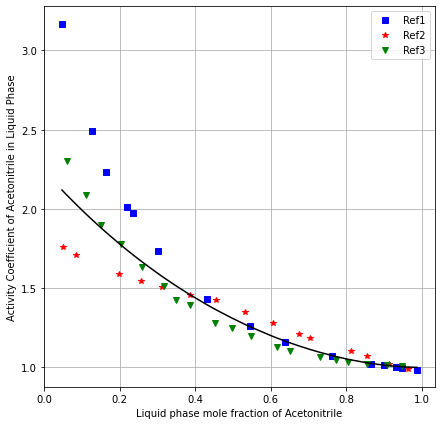

In [23]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["gamma_1"], 'bs')
plt.plot(df_2["x1"], df_2["gamma_1"], 'r*')
plt.plot(df_3["x1"], df_3["gamma_1"], 'gv')
plt.plot(df_vle.sort_values("x1")["x1"], df_nrtl_gammas["gamma_nrtl_1"],'k')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of Acetonitrile in Liquid Phase")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

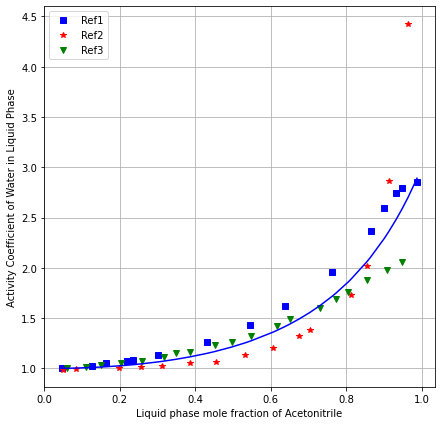

In [24]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["gamma_2"], 'bs')
plt.plot(df_2["x1"], df_2["gamma_2"], 'r*')
plt.plot(df_3["x1"], df_3["gamma_2"], 'gv')
plt.plot(df_vle.sort_values("x1")["x1"], df_nrtl_gammas["gamma_nrtl_2"],'b')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of Water in Liquid Phase")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

## Error Analysis: <br>  <br> $ d_{12} \; = \;  \frac{\partial \: \gamma(a_{12}, a_{21})}{\partial \: a_{12}} $ ; $ d_{21} \; = \;  \frac{\partial \: \gamma(a_{12}, a_{21})}{\partial \: a_{21}} $

In [25]:
a12_opt, a21_opt = optimized_actl_ipa_vle_nrtl_parameters['x']

dn = 0.0000001

a12, a21 = a12_opt*(1.0), a21_opt*(1.0)
nrtl.populate_matrix("A",{"actl-ipa":[a12,a21]})
df_nrtl_gammas = df_vle.sort_values("x1").apply(get_nrtl_gammas, axis=1, args=(nrtl,))

a12, a21 = a12_opt*(1.0+dn), a21_opt*(1.0)
nrtl.populate_matrix("A",{"actl-ipa":[a12,a21]})
df_nrtl_gammas_a12 = df_vle.sort_values("x1").apply(get_nrtl_gammas, axis=1, args=(nrtl,))

a12, a21 = a12_opt*(1.0), a21_opt*(1.0+dn)
nrtl.populate_matrix("A",{"actl-ipa":[a12,a21]})
df_nrtl_gammas_a21 = df_vle.sort_values("x1").apply(get_nrtl_gammas, axis=1, args=(nrtl,))

d_a12 = (df_nrtl_gammas_a12 - df_nrtl_gammas)/(a12_opt*dn)
d_a21 = (df_nrtl_gammas_a21 - df_nrtl_gammas)/(a21_opt*dn)

In [26]:
A1 = np.array([list(d_a12.gamma_nrtl_1),
                  list(d_a21.gamma_nrtl_1),
                  ]).T
A2 = np.array([list(d_a12.gamma_nrtl_2),
                  list(d_a21.gamma_nrtl_2),
                  ]).T
H1 = np.dot(A1.T, A1)
H2 = np.dot(A2.T, A2)

C1 = np.linalg.inv(H1)
C2 = np.linalg.inv(H2)

In [27]:
print("With respect to gamma_1")
print("a12 = %f +/- %f i.e. +/- %f percent"%(a12_opt, 1.96*np.sqrt(C1[0,0]), 1.96*np.sqrt(C1[0,0])/a12_opt*100))
print("a21 = %f +/- %f i.e. +/- %f percent"%(a21_opt, 1.96*np.sqrt(C1[1,1]), 1.96*np.sqrt(C1[1,1])/a21_opt*100))
print("With respect to gamma_2")
print("a12 = %f +/- %f i.e. +/- %f percent"%(a12_opt, 1.96*np.sqrt(C2[0,0]), 1.96*np.sqrt(C2[0,0])/a12_opt*100))
print("a21 = %f +/- %f i.e. +/- %f percent"%(a21_opt, 1.96*np.sqrt(C2[1,1]), 1.96*np.sqrt(C2[1,1])/a21_opt*100))


With respect to gamma_1
a12 = 1.069942 +/- 3.650356 i.e. +/- 341.173367 percent
a21 = 0.030406 +/- 2.225077 i.e. +/- 7317.880221 percent
With respect to gamma_2
a12 = 1.069942 +/- 2.273641 i.e. +/- 212.501399 percent
a21 = 0.030406 +/- 1.994774 i.e. +/- 6560.453299 percent


In [28]:
D1 = np.array([
    list(d_a12.gamma_nrtl_1),
    list(d_a21.gamma_nrtl_1),
]).T

D2 = np.array([
    list(d_a12.gamma_nrtl_2),
    list(d_a21.gamma_nrtl_2),
]).T

err1, err2 = [], []
for i in range(len(D1)):
    d1 = D1[i]
    d2 = D2[i]
    e1 = np.dot(d1, np.dot(C1, d1.T))
    e2 = np.dot(d2, np.dot(C2, d2.T))
    err1.append(e1)
    err2.append(e2)
err1 = np.array(err1)
err2 = np.array(err2)


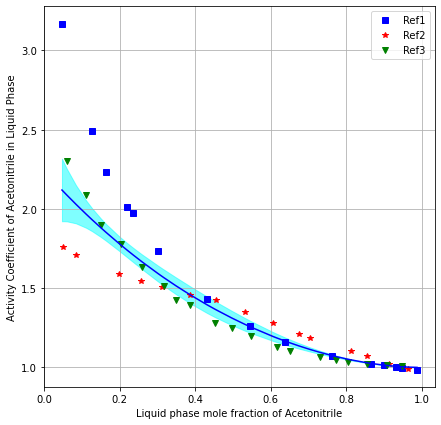

In [29]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["gamma_1"], 'bs')
plt.plot(df_2["x1"], df_2["gamma_1"], 'r*')
plt.plot(df_3["x1"], df_3["gamma_1"], 'gv')
plt.plot(df_vle.sort_values("x1")["x1"], df_nrtl_gammas["gamma_nrtl_1"],'b')
plt.fill_between(df_vle.sort_values("x1")["x1"], 
                 df_nrtl_gammas["gamma_nrtl_1"] - err1,
                 df_nrtl_gammas["gamma_nrtl_1"] + err1,
                 color = 'cyan', alpha = 0.5)
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of Acetonitrile in Liquid Phase")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

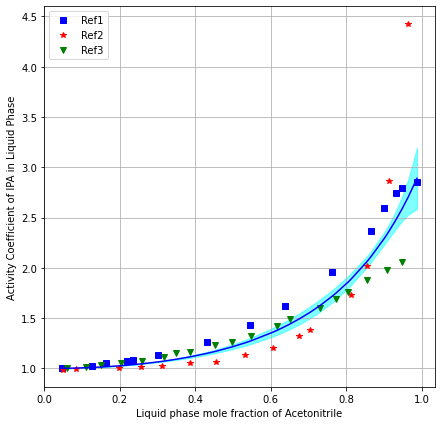

In [30]:
plt.figure(figsize = (7,7))
plt.plot(df_1["x1"], df_1["gamma_2"], 'bs')
plt.plot(df_2["x1"], df_2["gamma_2"], 'r*')
plt.plot(df_3["x1"], df_3["gamma_2"], 'gv')
plt.plot(df_vle.sort_values("x1")["x1"], df_nrtl_gammas["gamma_nrtl_2"],'b')
plt.fill_between(df_vle.sort_values("x1")["x1"], 
                 df_nrtl_gammas["gamma_nrtl_2"] - err2,
                 df_nrtl_gammas["gamma_nrtl_2"] + err2,
                 color = 'cyan', alpha = 0.5)

plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of IPA in Liquid Phase")
plt.legend(["Ref1","Ref2","Ref3"])
plt.grid()

In [31]:
class ErrorNRTL:
    def __init__(self, nrtl, optimized_parameters, dict_covariance_matrix):
        self.nrtl = nrtl
        self.dict_covariance_matrix = dict_covariance_matrix
        self.optimized_parameters = optimized_parameters
    def get_error_in_best_fit_gammas(self, T, dict_mol_fractions):
        '''
        returns a dictionary with names as keys and a tuple as value.
        First element of the tuple is the best fit gamma
        Second element of the tuple is the 95% uncertainty in gamma
        '''
        nrtl = self.nrtl
        a12_opt, a21_opt = self.optimized_parameters
        dn = 0.000001
        
        a12, a21 = a12_opt*(1.0), a21_opt*(1.0)
        nrtl.populate_matrix("A",{"actl-ipa":[a12,a21]})
        dict_gammas = nrtl.get_gammas(T, dict_mol_fractions)

        a12, a21 = a12_opt*(1.0+dn), a21_opt*(1.0)
        nrtl.populate_matrix("A",{"actl-ipa":[a12,a21]})
        dict_gammas_a12 = nrtl.get_gammas(T, dict_mol_fractions)

        a12, a21 = a12_opt*(1.0), a21_opt*(1.0+dn)
        nrtl.populate_matrix("A",{"actl-ipa":[a12,a21]})
        dict_gammas_a21 = nrtl.get_gammas(T, dict_mol_fractions)

        d1_a12 = (dict_gammas_a12["actl"] - dict_gammas["actl"])/(a12*dn)
        d1_a21 = (dict_gammas_a21["actl"] - dict_gammas["actl"])/(a21*dn)
        
        d2_a12 = (dict_gammas_a12["ipa"] - dict_gammas["ipa"])/(a12*dn)
        d2_a21 = (dict_gammas_a21["ipa"] - dict_gammas["ipa"])/(a21*dn)
        
        D1 = np.array([d1_a12, d1_a21]).reshape((2,1))
        D2 = np.array([d2_a12, d2_a21]).reshape((2,1))
        
        err1 = 1.96*np.dot(D1.T, np.dot(self.dict_covariance_matrix["actl"],D1))[0,0]        
        err2 = 1.96*np.dot(D2.T, np.dot(self.dict_covariance_matrix["ipa"],D2))[0,0]
        return {"actl":[dict_gammas["actl"], err1], "ipa":[dict_gammas["ipa"], err2]}
        

In [32]:
errorNRTL =  ErrorNRTL(nrtl, 
                      optimized_actl_ipa_vle_nrtl_parameters['x'],
                     {"actl":C1, "ipa":C2})


In [33]:
errorNRTL.get_error_in_best_fit_gammas(273, {'actl':0.8, "ipa":1})

{'actl': [1.3772499731981735, 0.09954518258569542],
 'ipa': [1.1621837689898462, 0.03206388833516195]}

In [34]:
n = 100
actl_gamma = np.zeros((n,1))
ipa_gamma = np.zeros((n,1))
actl_error = np.zeros((n,1))
ipa_error = np.zeros((n,1))
x = np.linspace(0.01,0.99,n) ; T = 300
for i in range(n):
    dict_err = errorNRTL.get_error_in_best_fit_gammas(T, {'actl':x[i], "ipa":1-x[i]})
    actl_info, ipa_info = dict_err['actl'], dict_err['ipa']
    actl_gamma[i] = actl_info[0] ; actl_error[i] = actl_info[1]
    ipa_gamma[i] = ipa_info[0] ; ipa_error[i] = ipa_info[1]
    


    

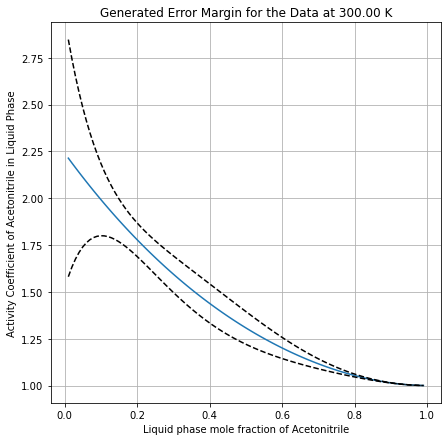

In [35]:
plt.figure(figsize = (7,7))
plt.plot(x, actl_gamma)
plt.plot(x, actl_gamma+actl_error , 'k--')
plt.plot(x, actl_gamma-actl_error , 'k--')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of Acetonitrile in Liquid Phase") ;
plt.title('Generated Error Margin for the Data at %.2f K'%(T)) ; plt.grid()

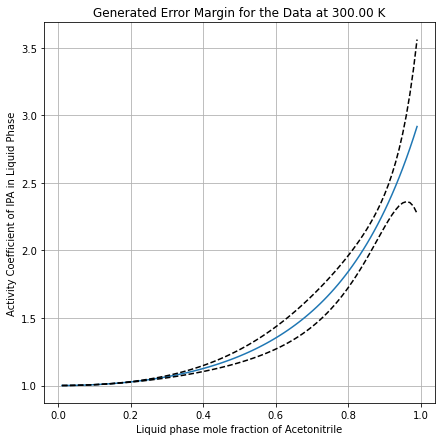

In [36]:
plt.figure(figsize = (7,7))
plt.plot(x, ipa_gamma)
plt.plot(x, ipa_gamma+ipa_error , 'k--')
plt.plot(x, ipa_gamma-ipa_error , 'k--')
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Activity Coefficient of IPA in Liquid Phase") ;
plt.title('Generated Error Margin for the Data at %.2f K'%(T)) ;
plt.grid()

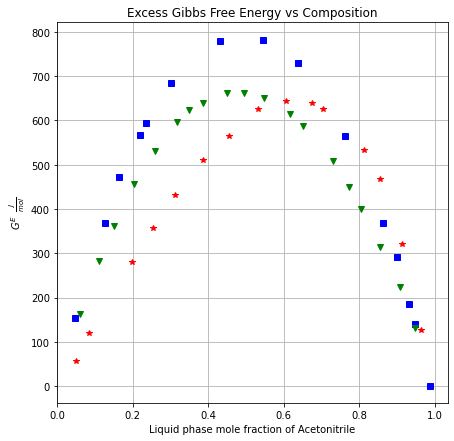

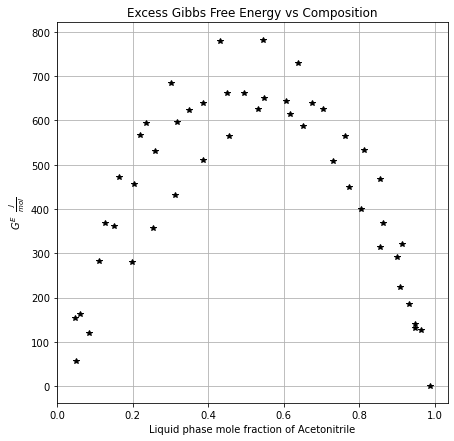

In [37]:
Ge_nrtl_expt = 8.314462*df_vle['T']*(df_vle['x1']*np.log(df_vle['gamma_1']) + (1-df_vle['x1'])*np.log(df_vle['gamma_2']))
Ge1_nrtl = 8.314462*df_1["T"]*(df_1['x1']*np.log(df_1['gamma_1']) + (1-df_1['x1'])*np.log(df_1['gamma_2']))
Ge2_nrtl = 8.314462*df_2["T"]*(df_2['x1']*np.log(df_2['gamma_1']) + (1-df_2['x1'])*np.log(df_2['gamma_2']))
Ge3_nrtl = 8.314462*df_3["T"]*(df_3['x1']*np.log(df_3['gamma_1']) + (1-df_3['x1'])*np.log(df_3['gamma_2']))
plt.figure(figsize = (7,7))
plt.plot(df_1['x1'], Ge1_nrtl, 'bs' )
plt.plot(df_2['x1'], Ge2_nrtl, 'r*' )
plt.plot(df_3['x1'], Ge3_nrtl, 'gv' )
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy vs Composition')
plt.grid()
plt.figure(figsize = (7,7))
plt.plot(df_vle['x1'], Ge_nrtl_expt, 'k*')
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy vs Composition');
plt.grid()

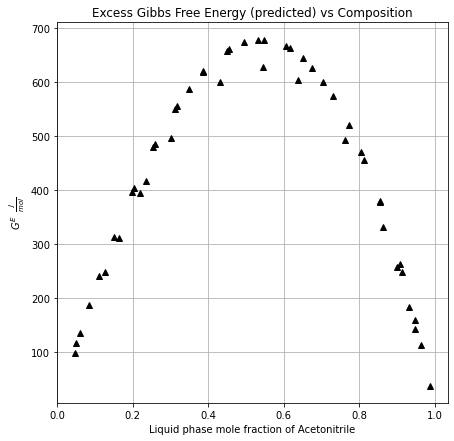

In [38]:
Ge_nrtl_pred = 8.314463*df_vle.sort_values("x1")["T"]*(df_vle.sort_values("x1")["x1"]*np.log(df_nrtl_gammas["gamma_nrtl_1"]) + (1-df_vle.sort_values("x1")["x1"])*np.log(df_nrtl_gammas["gamma_nrtl_2"]))
plt.figure(figsize = (7,7))
plt.plot(df_vle.sort_values("x1")["x1"], Ge_nrtl_pred, 'k^')
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy (predicted) vs Composition')
plt.grid()

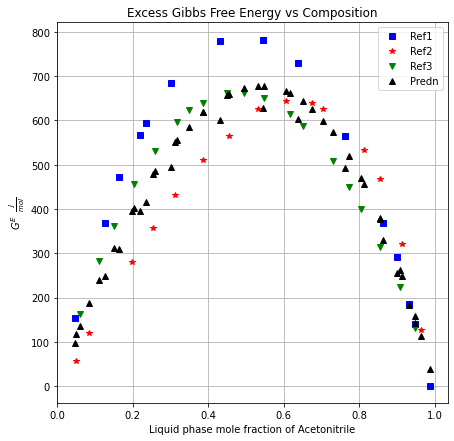

In [39]:
plt.figure(figsize = (7,7))
plt.plot(df_1['x1'], Ge1_nrtl, 'bs' )
plt.plot(df_2['x1'], Ge2_nrtl, 'r*' )
plt.plot(df_3['x1'], Ge3_nrtl, 'gv' )

plt.plot(df_vle.sort_values("x1")["x1"], Ge_nrtl_pred, 'k^' )
plt.legend(['Ref1', 'Ref2', 'Ref3', 'Predn'])
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy vs Composition')
plt.grid()

## Wilsons Model : <br> $$ \frac{G^{E}}{RT} = -x_{1}ln(x_{1}+x_{2}\Lambda_{12}) -x_{2}ln(x_{2}+x_{1}\Lambda_{21}) $$ <br> $$ln(\gamma_{1}) = -ln(x_{1}+x_{2}\Lambda_{12}) + x_{2}( \frac{\Lambda_{12}}{x_{1}+x_{2}\Lambda_{12}} - \frac{\Lambda_{21}}{x_{2}+x_{1}\Lambda_{21}} ) $$ <br>  $$ ln(\gamma_{2}) = -ln(x_{2}+x_{1}\Lambda_{21}) - x_{1}( \frac{\Lambda_{12}}{x_{1}+x_{2}\Lambda_{12}} - \frac{\Lambda_{21}}{x_{2}+x_{1}\Lambda_{21}} ) $$ <br> $$ \Lambda_{12} \; and \; \Lambda_{21} \; are \; the \; two \; parameters \; given\; by \: : $$ <br> $$ \Lambda_{12} = \frac{V_{2}}{V_{1}}exp( \frac{-(\lambda_{12}-\lambda_{11})}{RT} ) $$ <br> $$ \Lambda_{21} = \frac{V_{1}}{V_{2}}exp( \frac{-(\lambda_{12}-\lambda_{22})}{RT} ) $$ <br> $$ So \; essentially \; the \; parameters \; are \; (\lambda_{12} - \lambda_{11}) \; (say \; A_{1}) \; and \; (\lambda_{12} - \lambda_{22}) \; (say \; A_{2}) $$

## Lets use our Class Wilson!

## Fitting the model to the given Data: 

In [40]:
from Wilson.Wilson import Wilson
from scipy.optimize import minimize
x0 = np.zeros(2)
x0[0] = 0.1 ; x0[1] = 0.1
model = Wilson()
sol = minimize(model.ObjectiveFunc , x0 , args = (df_vle['x1'] , 
                                                  df_vle['T']  ,
                                                 Ge_nrtl_expt))
A1,A2 = sol.x[0],sol.x[1]

## Finding the Excess Gibbs Free Energy  :

In [41]:
wilson = Wilson()
T_K = df_vle['T'].to_numpy()
x1 = df_vle['x1'].to_numpy()
Ge_wilson_pred = np.zeros(len(x1))
for i in range(1,len(x1)-1):
        wilson.getParam(T_K[i], A1, A2)
        wilson.getGamma(T_K[i],x1[i], A1, A2)
        Ge_wilson_pred[i] = wilson.getGe(T_K[i],x1[i])
        


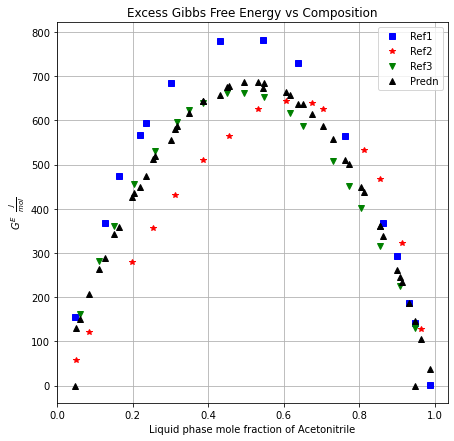

In [42]:
plt.figure(figsize = (7,7))
plt.plot(df_1['x1'], Ge1_nrtl, 'bs' )
plt.plot(df_2['x1'], Ge2_nrtl, 'r*' )
plt.plot(df_3['x1'], Ge3_nrtl, 'gv' )

plt.plot(df_vle["x1"], Ge_wilson_pred, 'k^' )
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy vs Composition')
plt.legend(['Ref1', 'Ref2', 'Ref3', 'Predn'])
plt.grid()

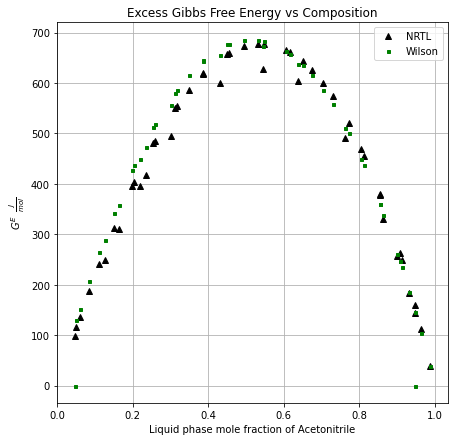

In [43]:
plt.figure(figsize = (7,7))
plt.plot(df_vle.sort_values("x1")["x1"], Ge_nrtl_pred, 'k^' )
plt.plot(df_vle["x1"], Ge_wilson_pred, 'gs', markersize = 3 )
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy vs Composition')
plt.legend(['NRTL', 'Wilson'])
plt.grid()

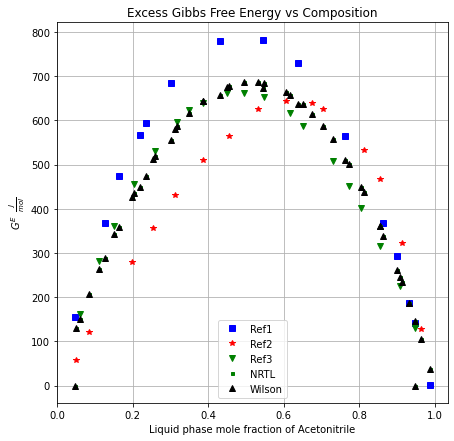

In [44]:
plt.figure(figsize = (7,7))
plt.plot(df_1['x1'], Ge1_nrtl, 'bs' )
plt.plot(df_2['x1'], Ge2_nrtl, 'r*' )
plt.plot(df_3['x1'], Ge3_nrtl, 'gv' )
plt.plot(df_vle["x1"], Ge_wilson_pred, 'gs', markersize = 3 )
plt.plot(df_vle["x1"], Ge_wilson_pred, 'k^' )
plt.legend(['Ref1', 'Ref2', 'Ref3', 'NRTL', 'Wilson'], loc = "lower center")
plt.xlabel('Liquid phase mole fraction of Acetonitrile')
plt.ylabel(r'$G^{E} \; \; \frac{J}{mol}$')
plt.title('Excess Gibbs Free Energy vs Composition')
plt.grid()

In [50]:
nrtl = NRTL.NRTL(["actl","ipa"])
nrtl.populate_matrix('A', {'actl-ipa': [1.06994155, 0.03040604]})
nrtl.populate_matrix('alpha',{'actl-ipa': [0.3, 0.3]})
dict_compounds = {"actl":actl, "ipa":ipa}

In [47]:
def get_residual_bubblepoint(T, dict_molfractions, nrtl, Ptotal):
    dict_gammas = nrtl.get_gammas(T, dict_molfractions)
    P = 0.0
    for name in dict_molfractions:
        P += dict_gammas[name]*dict_molfractions[name]*dict_compounds[name].Pvap(T)
    return Ptotal - P

def get_bubble_point(Ptotal, dict_molfractions):    
    Tbubble = scopt.newton(get_residual_bubblepoint, 300.0, args = (dict_molfractions, nrtl, Ptotal))
    return Tbubble


In [48]:
def get_residual_dewpoint(T, dict_molfractionsV, dict_molfractionsL, nrtl, Ptotal):
    gammas = nrtl.get_gammas(T, dict_molfractionsL)
    summ = 0.0
    for name in dict_molfractionsL:
        s = Ptotal * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
        summ += s
    return summ - 1

def get_dew_point(Ptotal, dict_molfractions):
    bool_go = True
    dict_molfractionsL = dict_molfractions.copy()
    dict_molfractionsV = dict_molfractions.copy()
    Told = 300.0
    while bool_go:
        T = scopt.newton(get_residual_dewpoint, Told, args=(dict_molfractionsV, dict_molfractionsL, nrtl, Ptotal))
        gammas = nrtl.get_gammas(T, dict_molfractionsL)
        sumx = 0.0
        for name in dict_molfractionsV:
            x = Ptotal * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
            dict_molfractionsL[name] = x
            sumx += x
        for name in dict_molfractionsL:
            dict_molfractionsL[name] /= sumx
        
        if abs(T - Told) < 0.1:
            bool_go = False
        else:
            Told = T + 0.0
        #print(T)
    return T

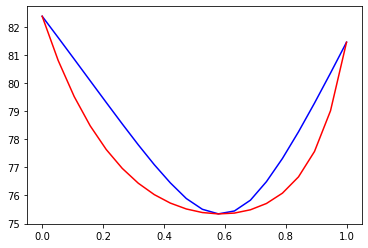

In [51]:
x = np.linspace(0,1, 20)
Tdew = np.zeros(len(x))
Tbub = np.zeros(len(x))
Pbub = np.zeros((len(x),1))
Pdew = np.zeros((len(x),1))
Ptotal = 1.013e5 #Pa
for i in range(len(x)):
    dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
    x1 = x[i] ; y1 = x[i]
    Tbub[i] =  get_bubble_point(Ptotal, dict_molfractions)-273.16
    Tdew[i] =  get_dew_point(Ptotal, dict_molfractions)-273.16
    
plt.plot(x, Tdew, 'b');
plt.plot(x, Tbub, 'r');